## An Introduction to Probabilistic Spiking Neural Networks

[[1]](https://arxiv.org/pdf/1910.01059.pdf)

## USPS dataset

[[2]](https://www.kaggle.com/bistaumanga/usps-dataset)

## Spatio-temporal correlations and visual signalling in a complete neuronal population

[[3]](https://www.nature.com/articles/nature07140)

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from math import exp
import pandas as pd
from scipy.stats import bernoulli
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec

from cycler import cycler


default_cycler = (cycler(color=['black', 'silver']) *
                  cycler(linestyle=['-', '--', ':', '-.']))
default_cycler2 = (cycler(color=['lightblue', 'slategray', 'darkgoldenrod','sienna', 'maroon']) +
                  cycler(linestyle=['-', '--', ':', '-.','-']))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import h5py
with h5py.File('usps.h5', 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

7


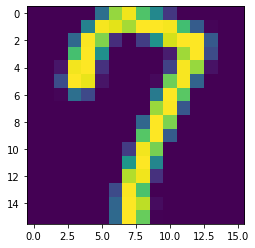

In [4]:
print(y_tr[3])
plt.imshow(X_tr[3,:].reshape(16,16), interpolation='nearest')
plt.show()

# Ones and sevens

### 500 training, 125 testing

In [5]:
y2_tr = y_tr[(y_tr == 1) | (y_tr == 7)][:500]
X2_tr = X_tr[(y_tr == 1) | (y_tr == 7),:][:500]
y2_te = y_te[(y_te == 1) | (y_te == 7)][:125]
X2_te = X_te[(y_te == 1) | (y_te == 7),:][:125]

# Rate encoding

> In this section we encode the USPS dataset by using  _rate encoding_. Each gray pixel is converted
into an input spiking signal by generating an independent identically distributed (i.i.d.) Bernoulli vector
of T samples, with the spiking probability proportional to the pixel intensity and limited to between zero
and 0.5 .

# Global parameters

In [6]:
# Number of output neoruns
output = 2
# Number of basis in forward filter
K = 12
# Spikes maximum steps
T = 32
# rate encoding probability inverse,
Freq = 3

In [7]:

train_size = X2_tr.shape[0]
image_size = X2_tr.shape[1]

# For each 16 x 16 image, we need a 256 x T array to fill the iid sampled vector
trainset = np.zeros((train_size, image_size, T))
train_y = np.zeros((2, train_size, T))

for image_index in range(train_size):
    # Note: We fill the true labels with a frequency of spikes
    #       defined as p (rate encoding probability inverse)
    #       False labels are zero arrays
    if y2_tr[image_index] == 1:
        train_y[0, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
    else:
        train_y[1, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
        
    image = X2_tr[image_index,:]    
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        trainset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)        
        

        
test_size = X2_te.shape[0]
testset = np.zeros((test_size, image_size, T))
for image_index in range(test_size):
    image = X2_te[image_index,:]
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        testset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)            

# Filter Kernels

### Raised Cosine Kernels
> We use the cosin basis that are represented in [[3]
](https://www.nature.com/articles/nature07140).

> Note that the time domian is in logarithmc scale. So, "this basis allows for the representation of fine temporal structure near the time of a spike and coarser/smoother dependency at later times"[[3]](https://www.nature.com/articles/nature07140)

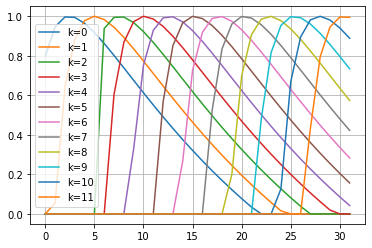

In [8]:
cosin_basis = np.zeros((K,T))
for k in range(K):
    cosin_basis[k,:] = np.cos(np.log(-k/2 + 7*np.pi/6 + (2*np.arange(0,T)-T)*np.pi/(T)))
    cosin_basis[k,cosin_basis[k,:] < 0 ] = 0
    #if k > 0 :
    #    cosin_basis[k, :k-1] = 0
        
    #cosin_basis[k, (T//2)+2*k:] = 0
    if k > 1 :
        cosin_basis[k, :(k+4)] = 0
    cosin_basis[k, :] = np.nan_to_num(cosin_basis[k, :])
    plt.plot(cosin_basis[k,:], label=f"k={k}")
    
plt.grid()
plt.legend()
plt.show()

# Convolution of two basis: Example

Convolution of K = 1, 4.3458
Convolution of K = 8, 3.8220


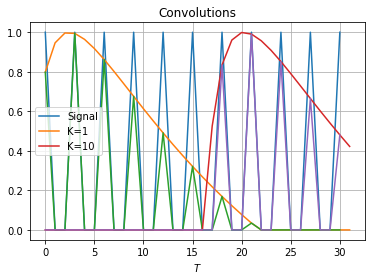

Convolution of K = 5, -4.2605


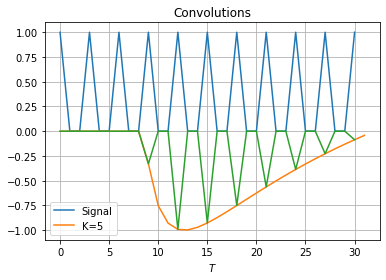

In [9]:
b = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
print(f"Convolution of K = 1, {np.sum(cosin_basis[0,:b.shape[0]]*b[::-1]):.4f}")
print(f"Convolution of K = 8, {np.sum(cosin_basis[7,:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(cosin_basis[0,:], label = "K=1")    
plt.plot(cosin_basis[0,:b.shape[0]]*b[::-1])

plt.plot(cosin_basis[7,:], label = "K=10")    
plt.plot(cosin_basis[7,:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

print(f"Convolution of K = 5, {np.sum(-cosin_basis[4,:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(-cosin_basis[4,:], label = "K=5")    
plt.plot(-cosin_basis[4,:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

# Feedback exponential Kernel

### Here, we create an exponential feedback filter an a second option.  Mathematically, it defines as $-\exp(-t/t_m)$, where $t_m$ denotes the scale length for exponential decreas in the time domain.

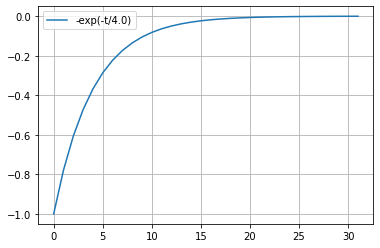

Convolution , -1.8948


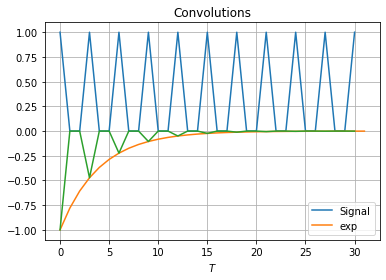

In [10]:
T_m = T/8
exp_basis = np.zeros(T)
for t in range(T):
    exp_basis[t] = -np.exp(-t/T_m)

plt.plot(exp_basis, label=f"-exp(-t/{T_m:.1f})")    
plt.grid()
plt.legend()
plt.show()    

b = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1])
print(f"Convolution , {np.sum(exp_basis[:b.shape[0]]*b[::-1]):.4f}")

plt.plot(b[::-1], label= "Signal")
plt.plot(exp_basis, label = "exp")    
plt.plot(exp_basis[:b.shape[0]]*b[::-1])

plt.title("Convolutions")
plt.legend()
plt.xlabel(r"$T$")
plt.grid()
plt.show()

# NN topology: No Hidden Layer

## Memberane potential, $u_{i, t}$ at time $t$:

## $u_{i, t} = \sum_{j \in \mathcal{P_j}} \omega_{j, i} \overrightarrow{s}_{j, t-1} + \omega_i \overleftarrow{s}_{i, t-1} + \gamma_i  \;\;\;\;\;\;\;\;\;\;\;\;\;$ (1)         

## where 
1. $\mathcal{P_j}$ is the set of pre-synaptic inputs for the neuron $i$.
2. $\omega_{j, i}$  is the feedforward weight for input $j$ to the neuron $i$.
3. $\omega_i$ is the feedback weight for the neuron $i$.
4. $\gamma_i$ is the bias parameter.
5. $\overrightarrow{s}_{j, t-1} = a_t * s_{j, t-1}$ for feedforward filter basis $a_t$ (2).
6. $\overleftarrow{s}_{i, t-1} = b_t * s_{j, t-1}$ for feedback filter basis $b_t$ (3).
7. $f_t * g_t = \sum_{\delta \ge 0} f_{\delta} g_{t - \delta}$ is a convolution operator (4).


# Learning by Maximum log-likelihood estimation ([1])

### The gradiant of the log-liklihood w.r.t. parameter $\boldsymbol{\theta_i}$ for neuron $i$
$\newcommand{\ora}[1]{\overrightarrow{#1}}$
$\newcommand{\ola}[1]{\overleftarrow{#1}}$
### $\nabla_{\boldsymbol{\theta_i}} \mathcal{L}_{\boldsymbol{S}\le T}(\boldsymbol{\theta}) = \sum_{t=0}^{T} \nabla_{\boldsymbol{\theta_i}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1})$

#### Note: The individual entries for each time step $t$ contributes as the summand of the sum.

### The gradiant w.r.t. weights

### $\nabla_{\gamma_i} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = s_{i,t} - \sigma(u_{i, t}),$

### $\nabla_{w_{i,j}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = \ora{s}_{j, t-1}(s_{i,t} - \sigma(u_{i, t})),$

### $\nabla_{w_{i}} \log P_{\boldsymbol{\theta_i}}  (s_i | \boldsymbol{s}_{\mathcal{P}_i \cup \{i\}, \le t-1}) = \ola{s}_{j, t-1}(s_{i,t} - \sigma(u_{i, t})),$

### where $\sigma(x) = 1/(1+\exp(-x))$


# Neuron Object:
> This class stores internal states such as previous memberance potentials. Calling output method for time $t$, moves the internal state one step forwrd. Similarly, calling gradiant method returns the MLE gradiant at time $t$ while moves the internal state one step forwrd.

# Now, we overfit the model for a single image

# Helper method

# Check the output of the trained model

> We feed the signle image that we used to train the model, for demonstration purpose (It never happens in real modelling). We expect to get the same rate encoding frequecny for the true case and zero for the false one

In [11]:
def sigmoid(x):
    return np.array(1/(1+np.exp(-x)))

def convolution(f_t, g_t):
    ''' See eq. (4)
    '''
    return np.dot(f_t, g_t[::-1])

class Neuron:
    def __init__(self, image_size, K, T,
                 synaptic_ws, feedback_ws, cross_feedback_ws, gamma, 
                 forwrd_basis, feedback_basis, cross_feedback_basis,
                 prob_threshold = .5):
        self.image_size = image_size
        self.K = K
        self.T = T
        self.prob_threshold = prob_threshold
        
        if len(feedback_basis.shape) == 1:
            self.feedbacks_K = 1
        else:
            self.feedbacks_K = K
            
        self.synaptic_ws = synaptic_ws
        self.feedback_ws = feedback_ws
        self.cross_feedback_ws = cross_feedback_ws
        self.gamma = gamma
        
        self.forwrd_basis = forwrd_basis
        self.feedback_basis = feedback_basis
        self.cross_feedback_basis = cross_feedback_basis
        
        self.fast_forward_basis = np.zeros((K, T, T))
        for k in range(K):
            for t in range(1, T+1):
                segment = forwrd_basis[k, :t]
                self.fast_forward_basis[k, t-1, :t] = segment[::-1]
                        
        self.reset()
        
    def reset(self):
        self.s_forward_t_1_s = np.zeros((self.image_size, self.K))
        if self.feedbacks_K == 1:
            self.s_feedback_t_1_s = np.zeros(1)        
        else:
            self.s_feedback_t_1_s = np.zeros(self.feedbacks_K)        
            
        self.s_cross_feedback_t_1_s = np.zeros(1)        
        self.u_i_t_1_s = np.zeros(self.T +1)
        self.previous_spikes = np.zeros(self.T +1)
        
           
    def output(self, image, t, cross_spikes_t_1):
        ''' Time is zero based, so, t referes to the current
            time and must start from 1.        
        '''        
        for k in range(self.K):
            for j in range(self.image_size):
                spikes = image[j, :t]                    
                # contribution from j input                                          
                # Convolution, see eq. (2)
                self.s_forward_t_1_s[j, k] = convolution(self.forwrd_basis[k, :t], spikes)
                if np.isnan(self.s_forward_t_1_s[j, k]):
                    print(f"NAN s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
                if np.isinf(self.s_forward_t_1_s[j, k]):
                    print(f"Inf s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
            # At time t = 1, we take the previous spike as zero
            # So, the feedback is zero too.
            if self.feedbacks_K > 1:
                # Feedback contribution
                # Convolution, see eq. (3)
                self.s_feedback_t_1_s[k] = convolution(self.feedback_basis[k, :t], self.previous_spikes[:t])  
        
        # At time t = 1, we take the previous spike as zero
        # So, the feedback is zero too.                        
        if self.feedbacks_K ==1:
            # Feedback contribution
            # Convolution, see eq. (1) 
            self.s_feedback_t_1_s = convolution(self.feedback_basis[:t], self.previous_spikes[:t]) 
            
        self.s_cross_feedback_t_1_s = convolution(self.cross_feedback_basis[:t], cross_spikes_t_1) 
            
        
        # Membrane potential
        # See eq. (1)
        u_i = (
               np.sum(self.synaptic_ws*self.s_forward_t_1_s)
             + np.sum(self.feedback_ws*self.s_feedback_t_1_s) 
             + self.cross_feedback_ws*self.s_cross_feedback_t_1_s
             + self.gamma
        )
        if np.isinf(u_i):
            print(f"Inf u_i i={self.i}")
            raise ValueError 
        # Output membrance potential        
        self.u_i_t_1_s[t] = u_i
        #self.previous_spikes[t] = bernoulli.rvs(sigmoid(u_i), size=1) 
        #self.previous_spikes[t] = sigmoid(u_i)
        self.previous_spikes[t] = 1 if sigmoid(u_i) >= self.prob_threshold else 0
            
        return (u_i, self.previous_spikes[:(t+1)])
    
    def gradiant(self, s_i, image, t, cross_spikes_t_1):
                
        u_i, spikes = self.output(image, t, cross_spikes_t_1)
        diff = s_i - sigmoid(u_i)        
        g_bias = diff            
        g_synaptic_ws = self.s_forward_t_1_s*diff        
        g_feedback_ws = self.s_feedback_t_1_s*diff
        g_cross_feedback_ws = self.s_cross_feedback_t_1_s*diff
        return (g_bias, g_synaptic_ws, g_feedback_ws, g_cross_feedback_ws, spikes)
    
        
    def output_f(self, image):
        ''' Faster version of the output method
            it returns an np array size T of u_i
        ''' 
        s_forward_T = np.einsum('ijk, lk -> jli', self.fast_forward_basis, image)
        forward_T = np.einsum('ijk, jk -> i', s_forward_T, self.synaptic_ws)
        u_i = forward_T + self.gamma
        
        
        if self.feedbacks_K > 1:
            s_feedback_T = np.zeros((K,T))
            for t in range(1, T):
                s_feedback_T[:, t] = np.einsum('ij, j -> ',
                                               self.feedback_basis[:,:t], 
                                               np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0))   
                u_i[t] += np.einsum('ij, ij -> ', s_feedback_T[:, t], self.feedback_ws)
        else:
            s_feedback_T = np.zeros(T)
            # Feedback contribution
            # Convolution, see eq. (1) 
            for t in range(1, T):
                s_feedback_T[t] = np.einsum('j, j -> ',
                                            self.feedback_basis[:t], 
                                            np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0)) 
                u_i[t] += self.feedback_ws*s_feedback_T[t]
        
        return u_i
    
            
    def update(self, image, label, eta):
        ''' Faster version of the output method
            it returns an np array size T of u_i
        ''' 
        s_forward_T = np.einsum('ijk, lk -> jli', self.fast_forward_basis, image)
        forward_T = np.einsum('ijk, jk -> i', s_forward_T, self.synaptic_ws)
        u_i = forward_T + self.gamma
        
        
        if self.feedbacks_K > 1:
            s_feedback_T = np.zeros((K,T))
            for t in range(1, T):
                s_feedback_T[:, t] = np.einsum('ij, j -> i',
                                               self.feedback_basis[:,:t], 
                                               np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0))                 
                u_i[t] += np.einsum('i, i -> ', s_feedback_T[:, t], self.feedback_ws)
        else:
            s_feedback_T = np.zeros(T)
            # Feedback contribution
            # Convolution, see eq. (1) 
            for t in range(1, T):
                s_feedback_T[t] = np.einsum('j, j -> ',
                                            self.feedback_basis[:t], 
                                            np.where(u_i[:t][::-1]>= self.prob_threshold, 1, 0)) 
                u_i[t] += self.feedback_ws*s_feedback_T[t]
        # Gradiant       
        g_bias = label - sigmoid(u_i)  
        self.gamma += eta*np.sum(g_bias)
        self.synaptic_ws += eta*np.einsum('ijk, i -> jk', s_forward_T, g_bias )        
        if self.feedbacks_K > 1:
            self.feedback_ws += eta*np.einsum('ij, j -> i', s_feedback_T, g_bias) 
        else:
            self.feedback_ws += eta*np.dot(s_feedback_T, g_bias )                
            
        return (u_i, np.sum(g_bias))

In [28]:
def init_ws(image_size, K, T, cosin_feedback = True, seed=44):
    if seed is not None:
        np.random.seed(seed)
    synaptic_ws = np.random.uniform(-1, 1, (output, image_size,  K))
    if cosin_feedback:
        feedback_ws = np.random.uniform(-1, 1, (output, K))
    else:
        feedback_ws = np.random.uniform(-1, 1, output)
        
    cross_feedback_ws = np.random.uniform(-1, 1, output)
    bias_paras = np.random.uniform(-1, 1, output)
    
    def init_neuron_cosine(i):
        '''Create a single neuron with
           inversed cosin basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      synaptic_ws[i,...], feedback_ws[i,:],cross_feedback_ws[i], bias_paras[i],                    
                      cosin_basis, -cosin_basis, exp_basis)
    
    def init_neuron_exp(i):
        '''Create a single neuron with
           exp basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      synaptic_ws[i,...], feedback_ws[i], cross_feedback_ws[i], bias_paras[i],                  
                      cosin_basis, exp_basis, exp_basis)
    if cosin_feedback:
        return init_neuron_cosine
    else:
        return init_neuron_exp

In [29]:
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=43)


image_index = 0

image = trainset[image_index, :, :]         
label = train_y[:, image_index, :] 

eta = 0.25
max_epoch = 600
Error_S = np.zeros((2, max_epoch))
network = [None, None]

neuron1 = init_neuron(0)
network[0] = neuron1
neuron2 = init_neuron(1)
network[1] = neuron2


for epo in range(max_epoch):
    
    spikes = [[0], [0]]
    
    for t in range(1, T):
        if t == 1:
            g_bias_1, g_synaptic_ws_1, g_feedback_ws_1, g_cross_feedback_ws_1, spikes_1 =  neuron1.gradiant(label[0, t-1], image, t, spikes[1])
        
            g_bias_2, g_synaptic_ws_2, g_feedback_ws_2, g_cross_feedback_ws_2, spikes_2 =  neuron2.gradiant(label[1, t-1], image, t, spikes[0])
        else:
            g_bias_12, g_synaptic_ws_12, g_feedback_ws_12, g_cross_feedback_ws_12, spikes_1 =  neuron1.gradiant(label[0, t-1], image, t, spikes[1])
            g_bias_1 += g_bias_12
            g_synaptic_ws_1 += g_synaptic_ws_12
            g_feedback_ws_1 += g_feedback_ws_12
            g_cross_feedback_ws_1 += g_cross_feedback_ws_12
            g_bias_22, g_synaptic_ws_22, g_feedback_ws_22, g_cross_feedback_ws_22, spikes_2 =  neuron2.gradiant(label[1, t-1], image, t, spikes[0])
            g_bias_2 += g_bias_22
            g_synaptic_ws_2 += g_synaptic_ws_22
            g_feedback_ws_2 += g_feedback_ws_22
            g_cross_feedback_ws_2 += g_cross_feedback_ws_22
        
        spikes = [spikes_1, spikes_2]

        Error_S[0, epo] += np.sum(g_bias_1**2)        
        Error_S[1, epo] += np.sum(g_bias_2**2)
        
    neuron1.gamma += eta*g_bias_1/(epo+1)
    neuron1.synaptic_ws += eta*g_synaptic_ws_1/(epo+1)
    neuron1.feedback_ws += eta*g_feedback_ws_1/(epo+1) 
    neuron1.cross_feedback_ws += eta*g_cross_feedback_ws_1/(epo+1) 

    neuron2.gamma += eta*g_bias_2/(epo+1)
    neuron2.synaptic_ws += eta*g_synaptic_ws_2/(epo+1)
    neuron2.feedback_ws += eta*g_feedback_ws_2/(epo+1) 
    neuron2.cross_feedback_ws += eta*g_cross_feedback_ws_2/(epo+1) 

    
    # Early stop
    if Error_S[1, epo] < 1e-4:
        #print(neuron.spikes(image))
        print(epo)            
        break
                

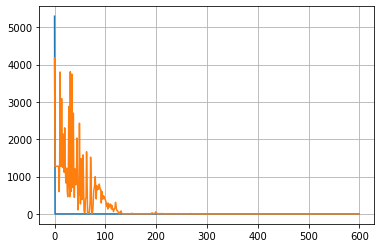

In [30]:
plt.plot(Error_S[0,:])
plt.plot(Error_S[1,:])
plt.grid()
plt.show()

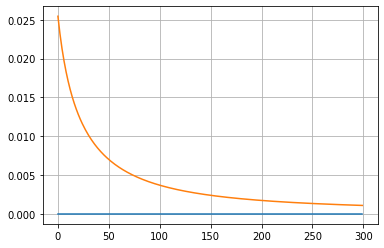

In [31]:
plt.plot(Error_S[0,300:])
plt.plot(Error_S[1,300:])
plt.grid()
plt.show()

In [32]:
def spikes_output(image, n1, n2):
    spikes = [[0], [0]]
    
    for t in range(1, T):
        _ , spikes_1 = n1.output(image, t, spikes[1])
        _ , spikes_2 = n2.output(image, t, spikes[0])
        
        spikes = [spikes_1, spikes_2]
    return (spikes[0], spikes[1])

In [33]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

str_first = "first"
str_second = "second"
print(f"Label: {y2_tr[image_index]}, so the { str_first if(y2_tr[image_index] == 1) else str_second}" 
      f" neuron predicts the True rate.")
#print(f"The rate encoding that we used for training model: {(1/p):.3f}")
print(f"The rate encoding that we used for first : {np.mean(moving_average(label[0,:], Freq)):.3f}")
print(f"The rate encoding that we used to train the model: {np.mean(moving_average(label[1,:], Freq)):.3f}")

n1 = network[0]
n2 = network[1]


n1_spikes, n2_spikes = spikes_output(image, n1, n2)

n1_pred = np.sum(n1_spikes)/len(n1_spikes)
n2_pred = np.sum(n2_spikes)/len(n2_spikes)

print(f"The rate encoding of the first neuron output: {np.mean(moving_average(n1_spikes, Freq)):.3f}")
print(f"The rate encoding of the second neuron output: {np.mean(moving_average(n2_spikes, Freq)):.3f}")

print(f"The rate encoding of the first neuron output: {n1_pred:.3f}")
print(f"The rate encoding of the second neuron output: {n2_pred:.3f}")

Label: 7, so the second neuron predicts the True rate.
The rate encoding that we used for first : 0.000
The rate encoding that we used to train the model: 0.333
The rate encoding of the first neuron output: 0.000
The rate encoding of the second neuron output: 0.333
The rate encoding of the first neuron output: 0.000
The rate encoding of the second neuron output: 0.344


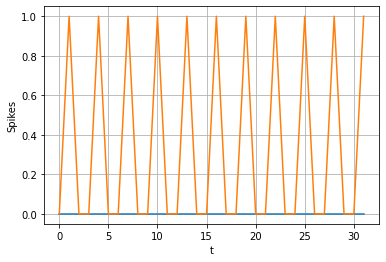

In [34]:
n1 = network[0]
n2 = network[1]

n1_spikes, n2_spikes = spikes_output(image, n1, n2)

plt.plot(n1_spikes)
plt.plot(n2_spikes)
plt.ylabel("Spikes")
plt.xlabel("t")
plt.grid()
plt.show()


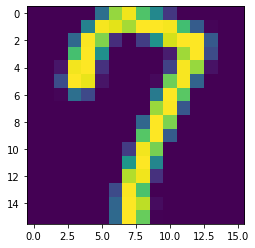

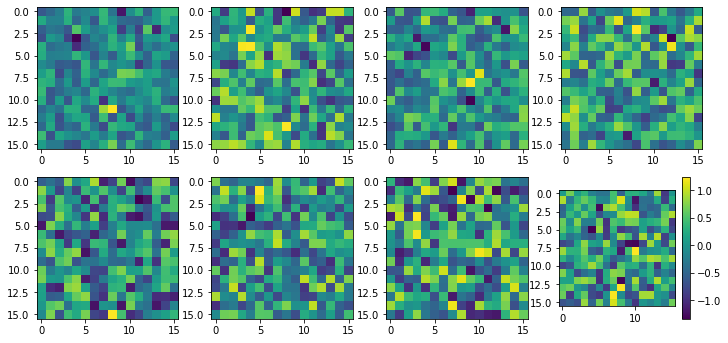

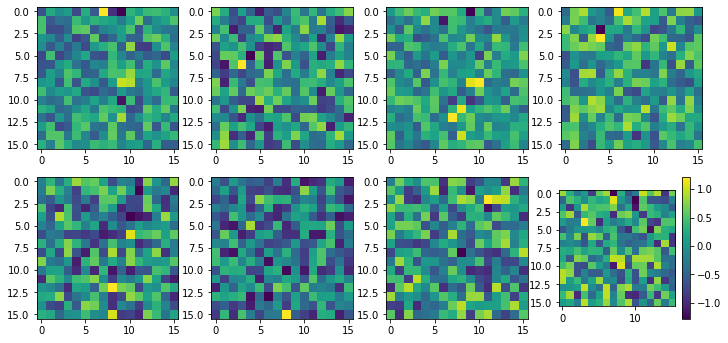

In [1169]:
plt.imshow(X_tr[3,:].reshape(16,16), interpolation='nearest')
plt.show()

for j in [0,1]:
    fig = plt.figure(figsize=(12, 12))
    gs=GridSpec(4,4)
    for i in range(8):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        plt.imshow(synaptic_ws_single[j,:,i].reshape((16,16)), interpolation='nearest')

    plt.colorbar()
    plt.show()